# Praktyczne zastosowanie modeli oceny wartości relacji z klientem w czasie.

#### Wczytanie bibliotek

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.dates import date2num
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import datetime


#### Konfiguracja

In [2]:
days_pl = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Niedziela']
months_pl = ['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień']

init_notebook_mode(connected=True)

plt.style.use('fivethirtyeight')

#### Wczytanie danych

In [27]:
df = pd.read_csv("./data/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


#### Analiza eksploracyjna danych

***InvoiceNo***: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
***StockCode***: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
***Description***: Product (item) name. Nominal. <br>
***Quantity***: The quantities of each product (item) per transaction. Numeric. <br>
***InvoiceDate***: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
***UnitPrice***: Unit price. Numeric, Product price per unit in sterling. <br>
***CustomerID***: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
***Country***: Country name. Nominal, the name of the country where each customer resides.

In [4]:
print(f'Liczba wierszy: {df.shape[0]} \nLiczba kolumn: {df.shape[1]}')

Liczba wierszy: 541909 
Liczba kolumn: 8


In [5]:
def summarizeDataframe( dataframe ):
    tab_info=pd.DataFrame(dataframe.dtypes).T.rename(index={0:'Column Type'})
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()).T.rename(index={0:'Missing values count'}))
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()/dataframe.shape[0]*100).T.
                            rename(index={0:'Percent of missing values'}))
    display(tab_info)

In [6]:
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,1454,0,0,0,135080,0
Percent of missing values,0,0,0.268311,0,0,0,24.9267,0


In [7]:

# Usunięcie obserwacji z brakującym "CustomerID"
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,0,0,0,0,0,0
Percent of missing values,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Ratio of missing values per columns')

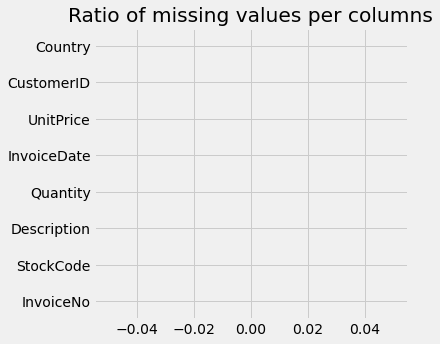

In [8]:
plt.figure(figsize=(5, 5))
df.isna().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

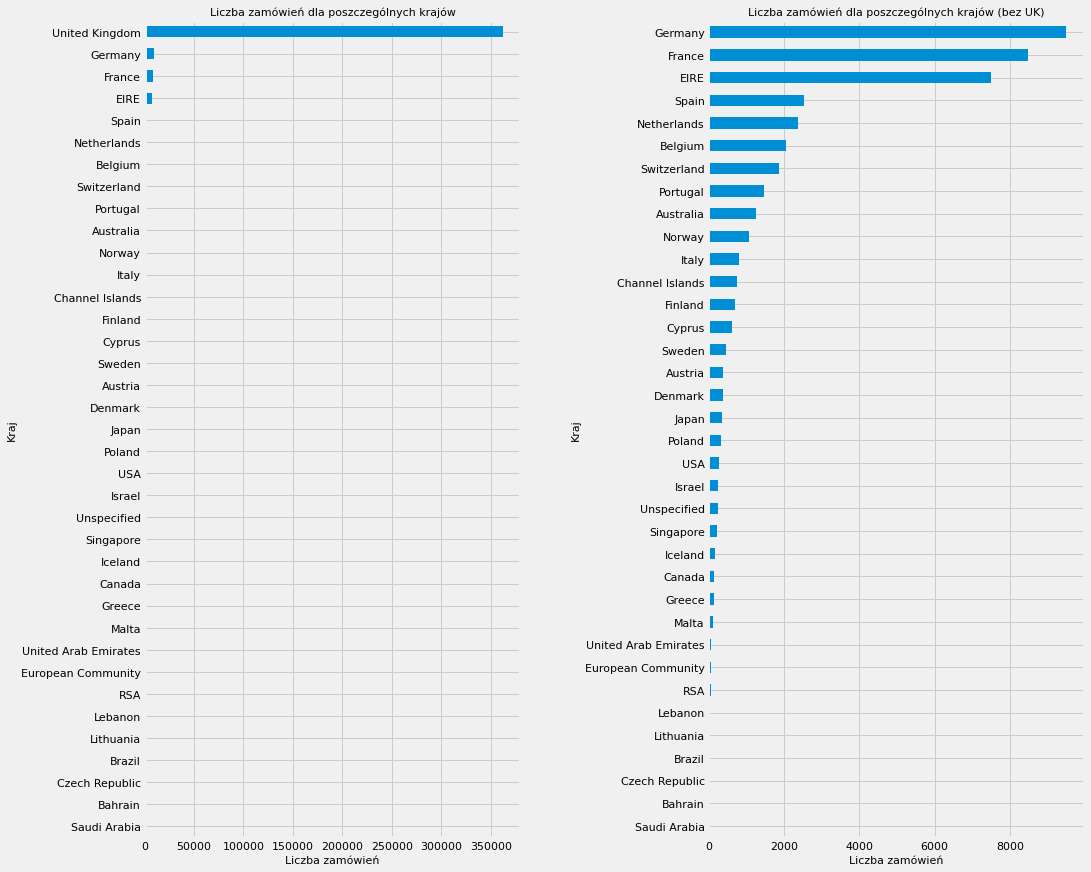

In [9]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique customers in each country
plt.subplot(1 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów', fontsize=11)

# plot number of unique customers in each country (without UK)
del group_country_orders['United Kingdom']
plt.subplot(1 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów (bez UK)', fontsize=11)

plt.show()

In [10]:
df['InvoiceDateFormat']=pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df.drop("InvoiceDayOfWeek", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeek', value=(df.InvoiceDateFormat.dt.day_name()))
df.drop("InvoiceDayOfWeekNumber", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeekNumber', value=(df.InvoiceDateFormat.dt.dayofweek))

df.drop("InvoiceMonth", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceMonth', value=(df.InvoiceDateFormat.dt.month_name()))

df.drop("InvoiceYear", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceYear', value=(df.InvoiceDateFormat.dt.year))

df.drop("InvoiceHour", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceHour', value=(df.InvoiceDateFormat.dt.hour))


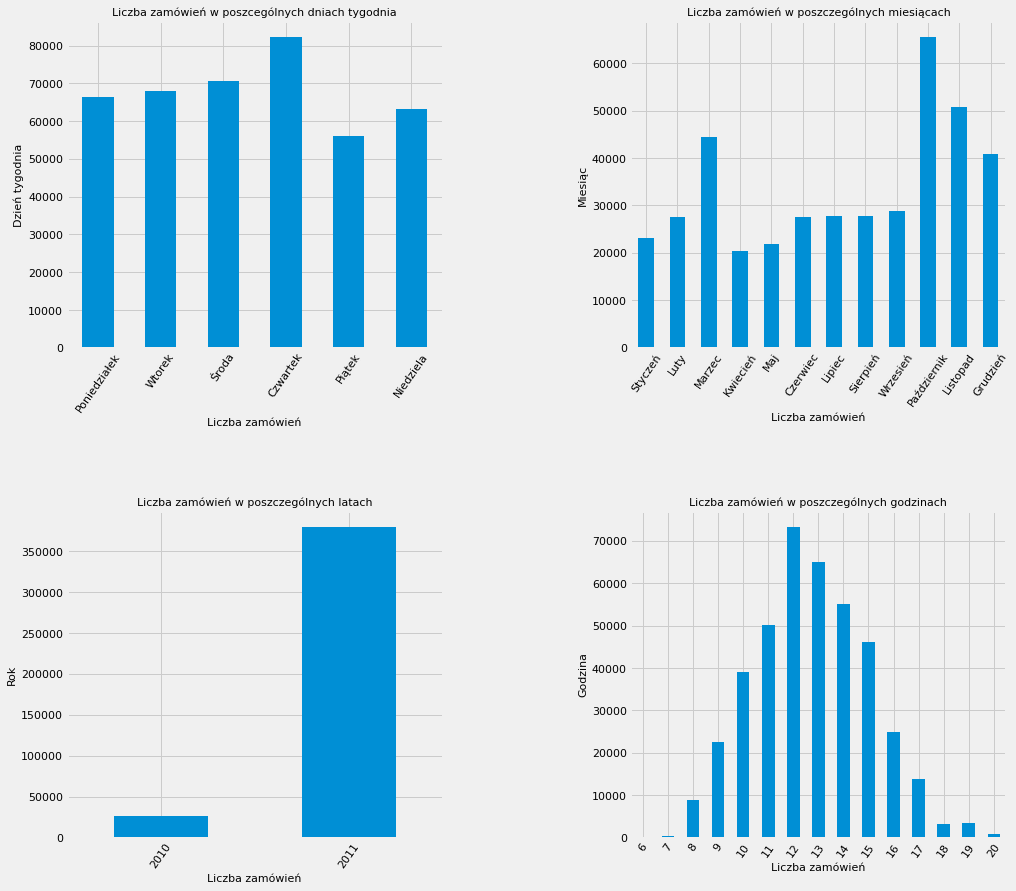

In [11]:

group_day_of_week_orders = df.groupby('InvoiceDayOfWeekNumber')['InvoiceNo'].count().sort_index()
group_month_orders = df.groupby('InvoiceMonth')['InvoiceNo'].count().sort_index()
group_year_orders = df.groupby('InvoiceYear')['InvoiceNo'].count().sort_index()
group_hour_orders = df.groupby('InvoiceHour')['InvoiceNo'].count().sort_index()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique orders in each day of week
plt.subplot(2 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_day_of_week_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Dzień tygodnia', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.title('Liczba zamówień w poszcególnych dniach tygodnia', fontsize=11)

# plot number of unique orders in each month
plt.subplot(2 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_month_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Miesiąc', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =months_pl, rotation = 55)
plt.title('Liczba zamówień w poszczególnych miesiącach', fontsize=11)

# plot number of unique orders in each year
plt.subplot(2 , 2 , 3)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_year_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Rok', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych latach', fontsize=11)

# plot number of unique orders in each hour
plt.subplot(2 , 2 , 4)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_hour_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Godzina', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych godzinach', fontsize=11)

plt.show()

In [12]:
df.drop("IsInvoiceCancelled", axis=1, errors='ignore', inplace = True)
df['IsInvoiceCancelled'] = df['InvoiceNo'].apply(lambda x: ('C' in x))

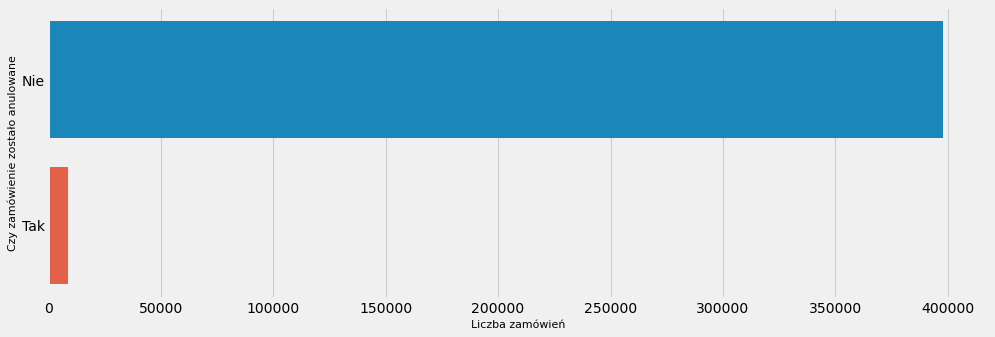

In [13]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'IsInvoiceCancelled' , data = df)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Czy zamówienie zostało anulowane', fontsize=11)
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels = ['Nie', 'Tak'])
plt.show()

In [14]:
df.drop("TotalPrice", axis=1, errors='ignore', inplace = True)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [15]:
revenue_df = df[['TotalPrice', 'InvoiceDateFormat']]
revenue_df['date'] = revenue_df['InvoiceDateFormat'].apply(lambda x: x.date())
revenue_by_date = revenue_df.groupby('date')['TotalPrice'].sum()

<ipython-input-15-1879701a72cd>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



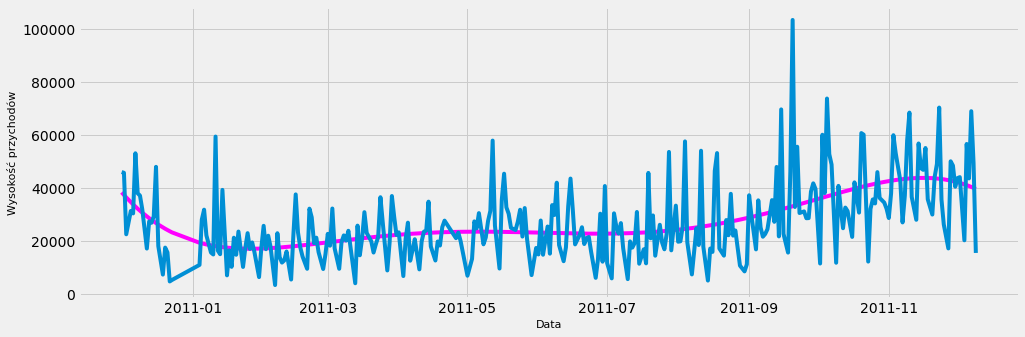

In [16]:
plt.figure(1 , figsize = (15 , 5))
z = np.polyfit(date2num(revenue_by_date.index), revenue_by_date.values, 5)
n = np.poly1d(z)(date2num(revenue_by_date.index))
# plt.plot(date2num(revenue_by_day.index), n)
# plt.plot(revenue_by_day.index, revenue_by_day.values)
sns.lineplot(date2num(revenue_by_date.index), n, color="magenta")
sns.lineplot(revenue_by_date.index, revenue_by_date.values)
plt.ylabel('Wysokość przychodów', fontsize=11)
plt.xlabel('Data', fontsize=11)
plt.show()

In [17]:
revenue_by_day = df.groupby('InvoiceDayOfWeekNumber')['TotalPrice'].sum().sort_index()

X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



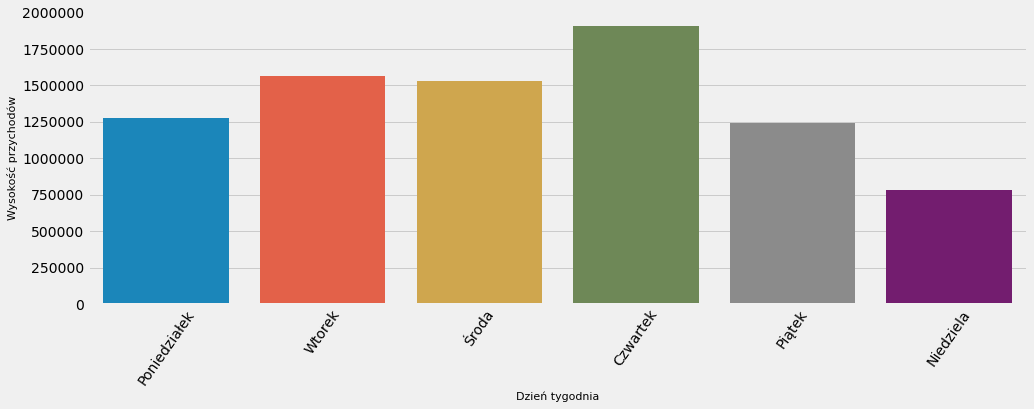

In [18]:
plt.figure(1 , figsize = (15 , 5))
sns.barplot(revenue_by_day.index, revenue_by_day.values)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.ylabel('Wysokość przychodów', fontsize=11, )
plt.xlabel('Dzień tygodnia', fontsize=11)
plt.ticklabel_format(useOffset = False, style = "plain", axis ='y')
plt.show()

<ipython-input-19-80c6787d21a9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



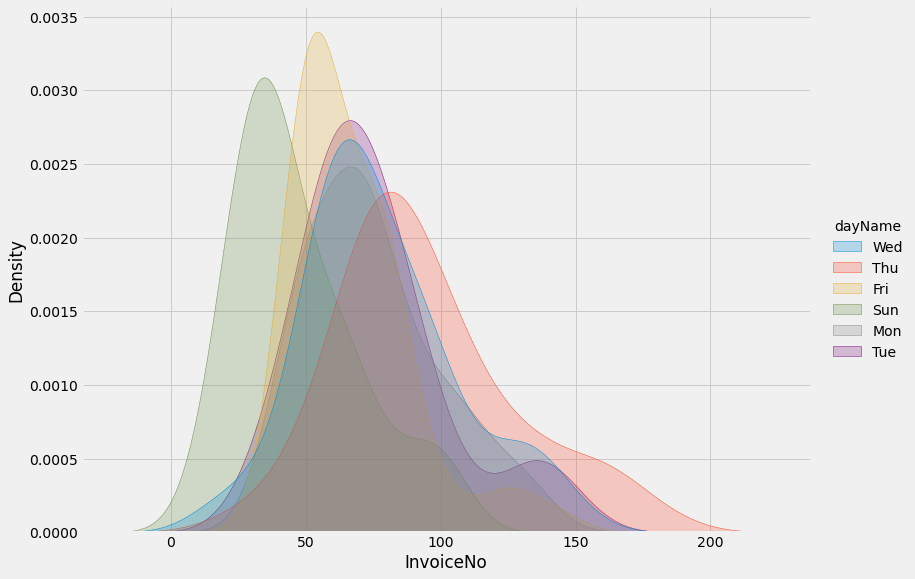

In [19]:
invoice_df = df[['InvoiceDateFormat', 'InvoiceNo']]
invoice_df['date'] = invoice_df['InvoiceDateFormat'].apply(lambda x: x.date())
invoice_count_by_day = invoice_df.groupby('date')['InvoiceNo'].nunique().reset_index()

# summarizeDataframe(invoice_count_by_day)

invoice_count_by_day['dayName'] = invoice_count_by_day['date'].apply(lambda x: x.strftime("%a"))



sns.displot(data=invoice_count_by_day, x="InvoiceNo", fill=True, hue = "dayName", kind = "kde", height=8.27, aspect=11.7/8.27)


In [20]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Ilość zamówień'},
colorscale=[[0, '#ffd1d1'],
            [0.005, '#ff9c9c'], [0.02, '#ff9c9c'],
            [1, '#fa0000']],    
reversescale = False)
#_______________________
layout = dict(title='Ilość zamówień w poszczególnych krajach', geo = dict(showframe = True, projection={'type':'equirectangular'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
choromap.update_layout(
    autosize = False,
    width = 1200,
    height = 650
)
iplot(choromap, validate=False)

### Transformacja zmiennych

In [21]:
transformed_df = pd.DataFrame()
transformed_df['CustomerID'] = df['CustomerID'].unique()
total_orders_value = df.groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'TotalOrdersValue'})
avg_order_value = df.groupby('CustomerID')['TotalPrice'].mean().to_frame().rename(columns={'TotalPrice' : 'AverageOrderValue'})
orders_count = df.groupby('CustomerID')['InvoiceNo'].nunique().to_frame().rename(columns={'InvoiceNo' : 'OrdersCount'})
min_order_value = df.groupby('CustomerID')['TotalPrice'].min().to_frame().rename(columns={'TotalPrice' : 'MinOrderValue'})
max_order_value = df.groupby('CustomerID')['TotalPrice'].max().to_frame().rename(columns={'TotalPrice' : 'MaxOrderValue'})
cancelled_orders_count = df.groupby('CustomerID')['IsInvoiceCancelled'].sum().to_frame().rename(columns={'IsInvoiceCancelled' : 'CancelledOrdersCount'})
cancelled_orders_value = df[df['IsInvoiceCancelled'] == True].groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'CancelledOrdersValue'})
now = datetime.datetime.now()
first_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].min()
last_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].max()
first_order_datetime = first_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceFirstOrder'})
last_order_datetime = last_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceLastOrder'})
days_since_first_order = (now - first_order_datetime['DaysSinceFirstOrder']).dt.days
days_since_last_order = (now - last_order_datetime['DaysSinceLastOrder']).dt.days

transformed_df = transformed_df.merge(total_orders_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(avg_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(min_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(max_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_value, how="left", on="CustomerID")
transformed_df = transformed_df.merge(days_since_first_order, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(days_since_last_order, how="inner", on="CustomerID")
transformed_df['CancelledOrdersValue'] = transformed_df['CancelledOrdersValue'].fillna(0)
transformed_df

,CustomerID,TotalOrdersValue,AverageOrderValue,OrdersCount,MinOrderValue,MaxOrderValue,CancelledOrdersCount,CancelledOrdersValue,DaysSinceFirstOrder,DaysSinceLastOrder
0,17850,5288.63,16.950737,35,-30.60,107.25,15,-102.58,4065,3994
1,13047,3079.10,15.709694,18,-15.00,68.00,24,-158.44,4065,3723
2,12583,7187.34,28.634821,18,-60.84,132.80,4,-94.04,4065,3694
3,13748,948.25,33.866071,5,9.36,204.00,0,0.00,4065,3787
4,15100,635.10,105.850000,6,-131.40,350.40,3,-240.90,4065,4022
...,...,...,...,...,...,...,...,...,...,...
4367,13436,196.89,16.407500,1,10.20,25.50,0,0.00,3693,3693
4368,15520,343.50,19.083333,1,9.48,34.68,0,0.00,3693,3693
4369,13298,360.00,180.000000,1,90.00,270.00,0,0.00,3693,3693
4370,14569,227.39,18.949167,1,1.65,122.40,0,0.00,3693,3693


### Klastryzacja

In [22]:
test = transformed_df[['TotalOrdersValue', 'MaxOrderValue']]
temp = test.iloc[: , :].values

def findBestN(matrix):
    for n in range(3,15):
        kmeans = KMeans(n_clusters = n, n_init=20, random_state=0 )
        kmeans.fit(matrix)
        clusters = kmeans.predict(matrix)
        silhouette_avg = silhouette_score(matrix, clusters)
        print("For n_clusters =", n, "The average silhouette_score is :", silhouette_avg)


findBestN(temp)

For n_clusters = 3 The average silhouette_score is : 0.9613894916177199
For n_clusters = 4 The average silhouette_score is : 0.9667372595307084
For n_clusters = 5 The average silhouette_score is : 0.8816869369303193
For n_clusters = 6 The average silhouette_score is : 0.8141265894566692
For n_clusters = 7 The average silhouette_score is : 0.7744410915125787
For n_clusters = 8 The average silhouette_score is : 0.7788918651005831
For n_clusters = 9 The average silhouette_score is : 0.7726712555337413
For n_clusters = 10 The average silhouette_score is : 0.7259477214638952
For n_clusters = 11 The average silhouette_score is : 0.6794980167848704
For n_clusters = 12 The average silhouette_score is : 0.681810252983146
For n_clusters = 13 The average silhouette_score is : 0.6774636737564812
For n_clusters = 14 The average silhouette_score is : 0.6354185827722574


In [23]:
es = temp[: , 0]

In [24]:
best_no_of_cluster= 4
algorithm = (KMeans(n_clusters = best_no_of_cluster ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='auto') )
algorithm.fit(temp)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [25]:
step = 20
x_min, x_max = temp[:, 0].min() - 1, temp[:, 0].max() + 1
y_min, y_max = temp[:, 1].min() - 1, temp[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

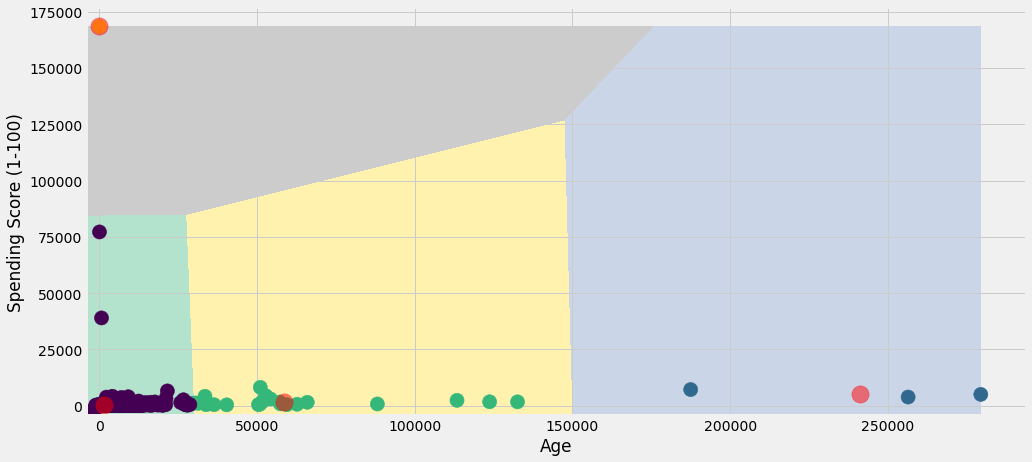

In [26]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'TotalOrdersValue' ,y = 'MaxOrderValue' , data = test , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()